## Семинар 2 "Распознавание рукописных цифр"

ФИО: Семенников Макар Алексеевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [2]:
import torch
import random
import os

def seed_everything(seed: int):
    # Для генератора случайных чисел Python
    random.seed(seed)
    
    # Для numpy
    np.random.seed(seed)
    
    # Для torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    # os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(42)

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

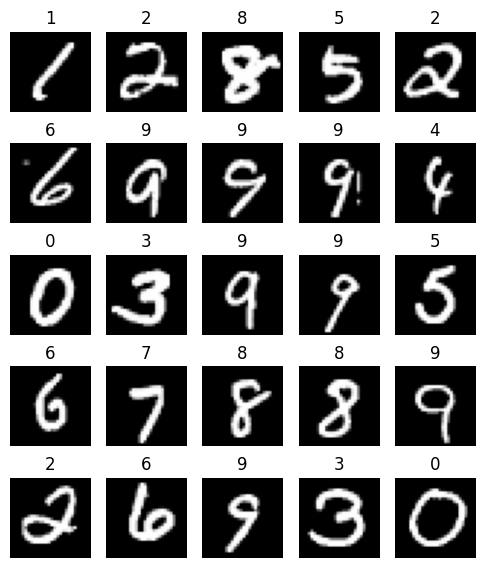

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [7]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

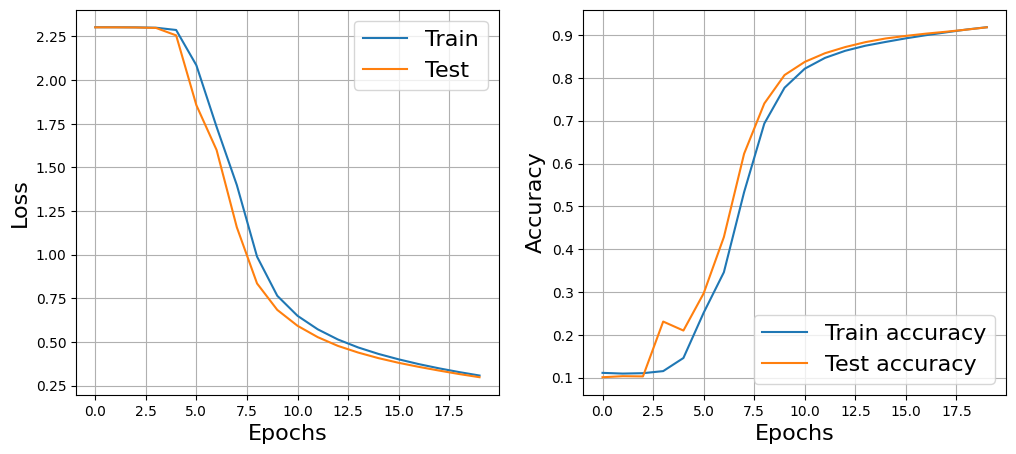

In [8]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

In [9]:
ts_ac_s[-1]

np.float64(0.9181309904153354)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [11]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

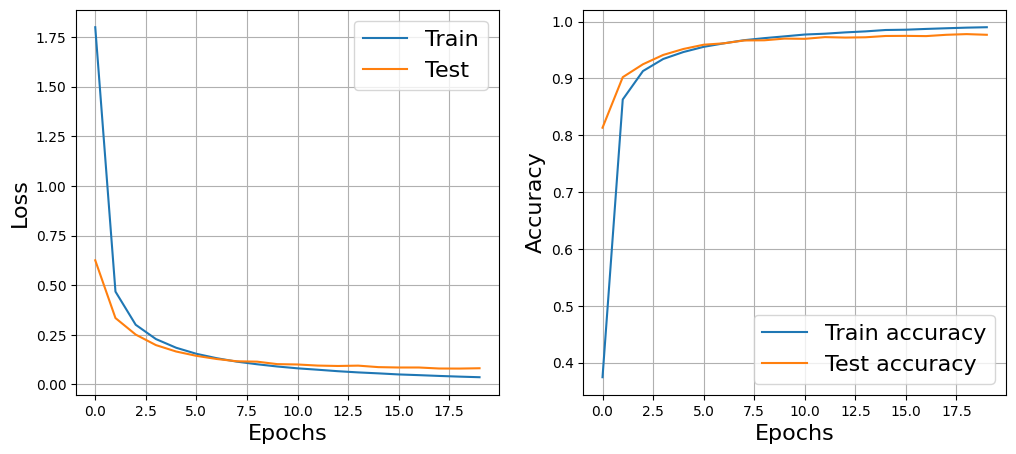

In [12]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

In [13]:
ts_ac_r[-1]

np.float64(0.9766373801916933)

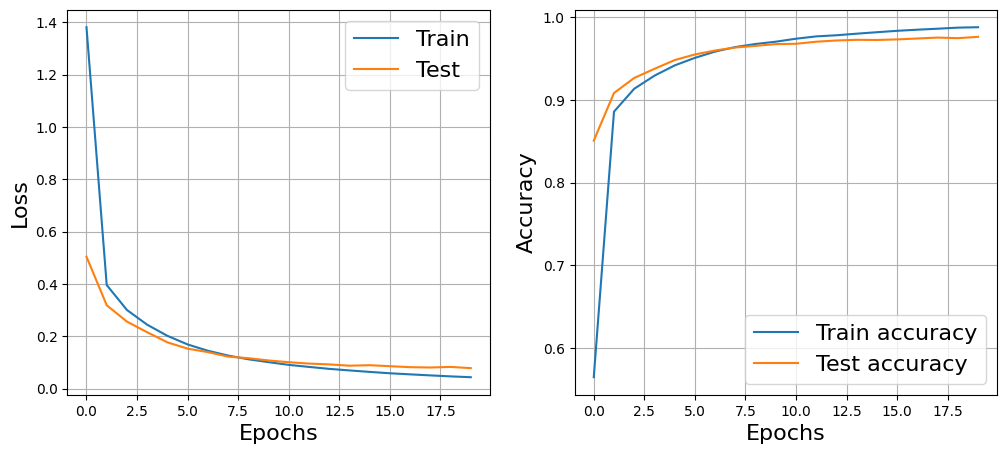

In [14]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

In [15]:
ts_ac_e[-1]

np.float64(0.9759384984025559)

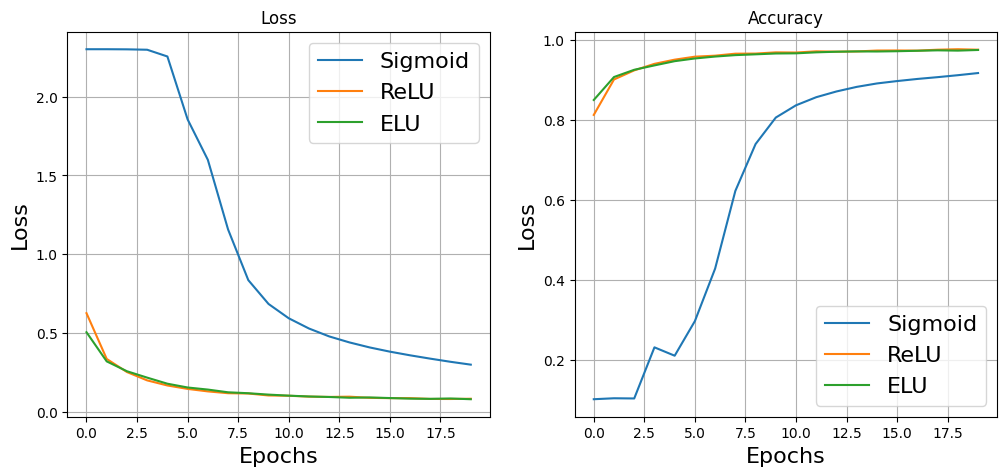

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

Реализуем функцию активации также в виде класса.

In [17]:
class TanH:
    def __init__(self):
        self.T = 0

    def forward(self, X):
        """
        Passes objects through this layer.
        X is np.array of size (N, d)
        """
        self.T = 2. / (1. + np.exp(- 2. * X)) - 1.
        return self.T

    def backward(self, dLdy):
        """
        1. Compute dLdx.
        2. Return dLdx
        """
        return (1. - np.square(self.T)) * dLdy

    def step(self, learning_rate):
        pass

Проверим работу нейросети с этой функцией активации

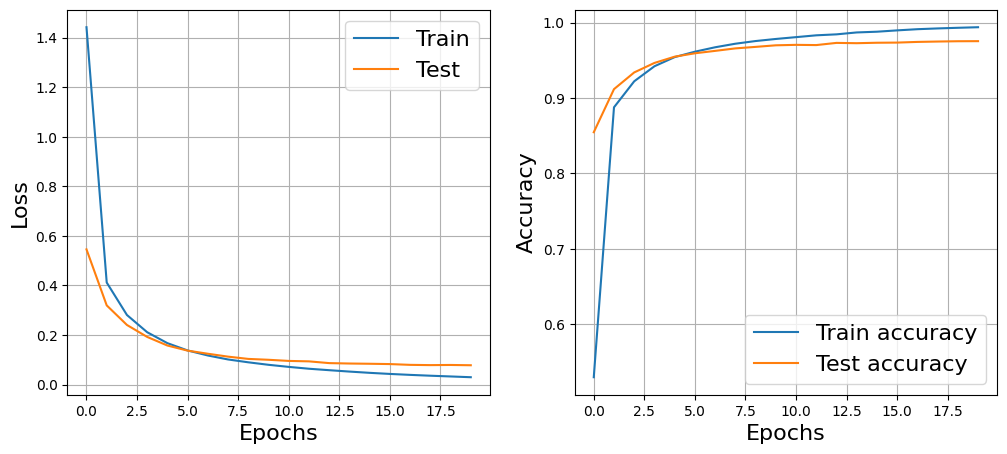

In [18]:
network = NeuralNetwork([Linear(784, 100), TanH(),
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

In [19]:
ts_ac_t[-1]

np.float64(0.9753394568690096)

Можно заметить, что и с функцией TanH нейросеть так же показывает хорошие результаты, как и с другими использованными функциями активации

### Часть 3: Анализ ошибок

In [20]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.vstack(wrong_X)
correct_y = np.vstack(correct_y)[:, 0]
predicted_y = np.vstack(predicted_y)[:, 0]
logits = np.vstack(logits)[:, 0]

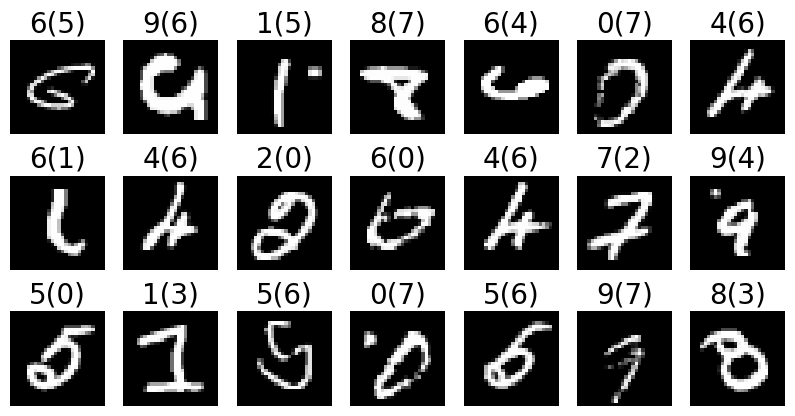

In [21]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

Какую-то закономерность в ошибках модели на первый взгляд заметить сложно. Некоторые случаи трудно оценить даже человеческим глазом.

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [22]:
from skimage.transform import rotate

Реализуем аугментацию в виде класса

In [23]:
class RotatedDataset(Dataset):
    def __init__(self, dataset, angle = (-15, 15)):
        self.dataset = dataset
        self.angle = angle
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        im, label = self.dataset[idx]
        
        im_np = im.numpy().squeeze()
        angle = np.random.uniform(*self.angle)
        rotated_im = rotate(im_np, angle, mode='wrap')
        
        rotated_im_tensor = torch.from_numpy(rotated_im).unsqueeze(0)
        return rotated_im_tensor, label

In [24]:
rotated_train_dataset = RotatedDataset(train_dataset)
rotated_train_loader = DataLoader(rotated_train_dataset, batch_size=32, shuffle=True)

Посмотрим - как изменились изображения. Для этого напишем функцию визуализации

In [25]:
def visualize_pictures(loader):
    augmented_images, labels = next(iter(loader))
    plt.figure(figsize=(6, 7))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(augmented_images[i].squeeze(), cmap=plt.cm.Greys_r)
        plt.title(labels[i].item())
        plt.axis('off')
    plt.show()

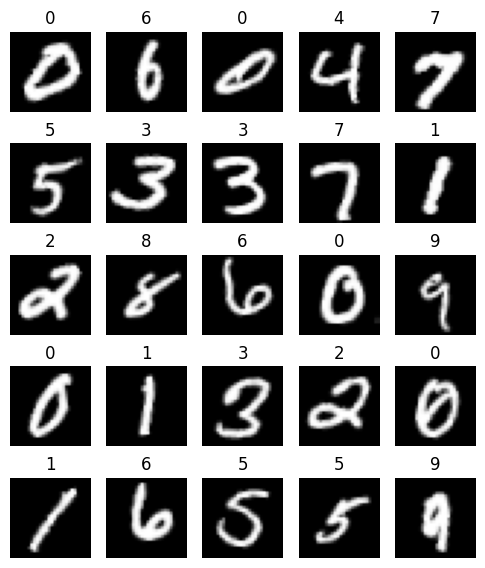

In [26]:
visualize_pictures(rotated_train_loader)

Слегка видоизменим функцию обучения, чтобы она принимала кастомный Data Loader в качестве аргумента

In [27]:
def train_custom(network, my_train_loader, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in my_train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Натренируем такую же нейросеть с TanH, вместо базового датасета подадим rotated_train_datase (соответственно rotated_train_loader)

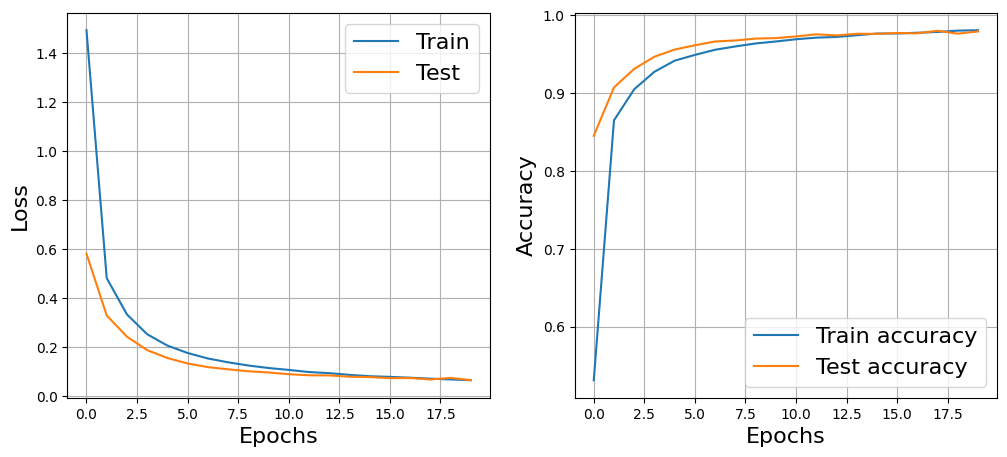

In [28]:
network = NeuralNetwork([Linear(784, 100), TanH(),
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train_custom(network, rotated_train_loader, 20, 0.01, plot=True, verbose=True)

In [29]:
ts_ac_r[-1]

np.float64(0.9791333865814696)

Мы видим, что результат улучшился, на небольшое значение, (~0.979 против ~0.975) но прирост точности на таких больших уровнях впечатляет. Но что ещё более важно - переобучение произошло не на 5-й эпохе а на 17.

Произведём оставшиеся манипуляции и посмотрим на результат.
Следующее - вращение.

In [30]:
from scipy.ndimage import shift


class ShiftedDataset(Dataset):
    def __init__(self, dataset, shift_range = (-5, 5)):
        self.dataset = dataset
        self.shift_range = shift_range
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        im, label = self.dataset[idx]
        
        im_np = im.numpy().squeeze()
        
        shift_x = np.random.uniform(*self.shift_range)
        shift_y = np.random.uniform(*self.shift_range)
        
        shifted_im = shift(im_np, shift=(shift_y, shift_x), mode='wrap')
        
        shifted_im_tensor = torch.from_numpy(shifted_im).unsqueeze(0)
        return shifted_im_tensor, label

In [31]:
shifted_dataset = ShiftedDataset(train_dataset)
shifted_train_loader = DataLoader(shifted_dataset, batch_size=32, shuffle=True)

Также посмотрим на изменения, произошедшие с картинками

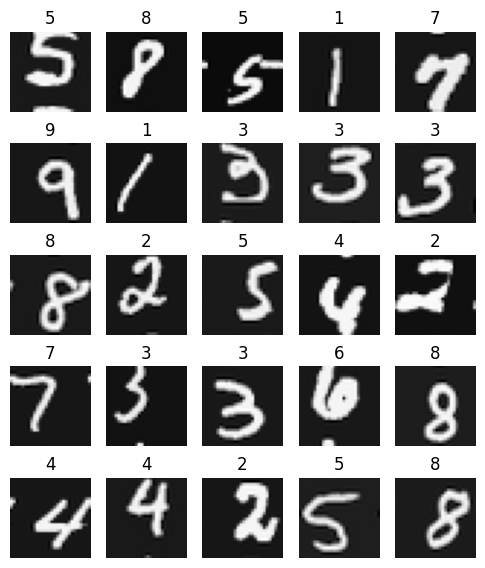

In [32]:
visualize_pictures(shifted_train_loader)

Как видно - картинки сдвинулись. Обучим нейросеть и посмотрим на результат

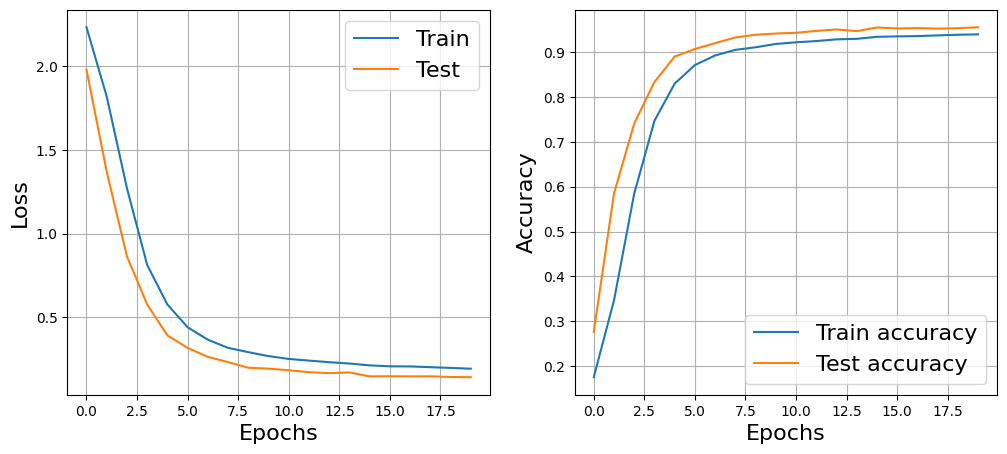

In [33]:
network = NeuralNetwork([Linear(784, 100), TanH(),
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_sh, ts_sh, tr_ac_sh, ts_ac_sh = train_custom(network, shifted_train_loader, 20, 0.01, plot=True, verbose=True)

In [34]:
ts_ac_sh[-1]

np.float64(0.955870607028754)

Получили результат слегка хуже, чем с повёрнутыми картинками и почти такой же - если сравнивать с изначальным датасетом. Однако при этом переобучения не произошло вообще, как следствие - при дальнейшем обучении модели в перспективе можно добиться лучших результатов.

Следующим этапом - попробуем "поиграться" с шумами.

In [35]:
class NoisyDataset(Dataset):
    def __init__(self, dataset, mean=0.0, std=0.2):
        self.dataset = dataset
        self.mean = mean
        self.std = std
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        im, label = self.dataset[idx]
        
        im_np = im.numpy().squeeze()
        
        noise = np.random.normal(self.mean, self.std, im_np.shape)
        
        noisy_im = im_np + noise
                
        noisy_im_tensor = torch.from_numpy(noisy_im).unsqueeze(0)
        return noisy_im_tensor, label


In [36]:
noisy_dataset = NoisyDataset(train_dataset)
noisy_train_loader = DataLoader(noisy_dataset, batch_size=32, shuffle=True)

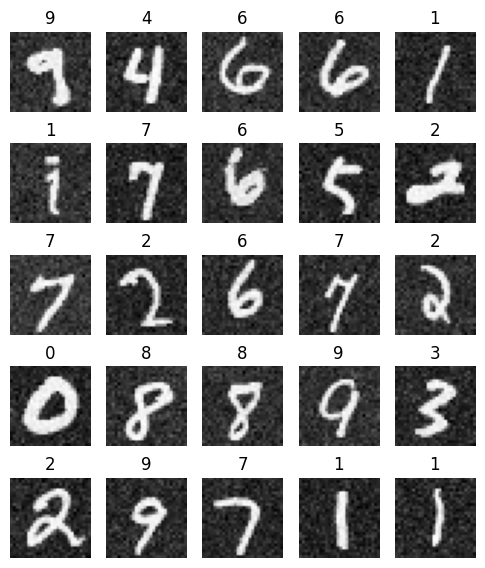

In [37]:
visualize_pictures(noisy_train_loader)

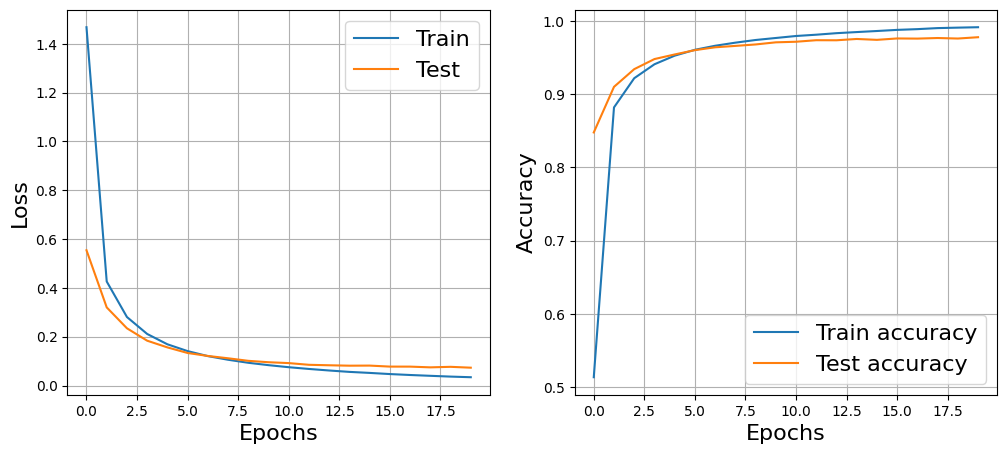

In [38]:
network = NeuralNetwork([Linear(784, 100), TanH(),
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_no, ts_no, tr_ac_no, ts_ac_no = train_custom(network, noisy_train_loader, 20, 0.01, plot=True, verbose=True)

In [39]:
ts_ac_no[-1]

np.float64(0.977935303514377)

Видно, что результат с шумом лучше, чем без шума, однако переобучение произошло слишком рано.

Теперь объединим все варианты аугментаций и посмотрим - что получится

In [40]:
class AugmentDataset(Dataset):
    def __init__(self, dataset, angle = (-15, 15), shift_range = (-5, 5), mean=0.0, std=0.2):
        self.dataset = dataset
        self.angle = angle
        self.shift_range = shift_range
        self.mean = mean
        self.std = std
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        im, label = self.dataset[idx]
        im_np = im.numpy().squeeze()
        
        angle = np.random.uniform(*self.angle)
        shift_x = np.random.uniform(*self.shift_range)
        shift_y = np.random.uniform(*self.shift_range)
        noise = np.random.normal(self.mean, self.std, im_np.shape)
        
        rotated_im = rotate(im_np, angle, mode='wrap')
        shifted_im = shift(rotated_im, shift=(shift_y, shift_x), mode='wrap')
        noisy_im = shifted_im + noise

        rotated_im_tensor = torch.from_numpy(noisy_im).unsqueeze(0)
        return rotated_im_tensor, label

In [41]:
augmented_dataset = AugmentDataset(train_dataset)
augmented_train_loader = DataLoader(augmented_dataset, batch_size=32, shuffle=True)

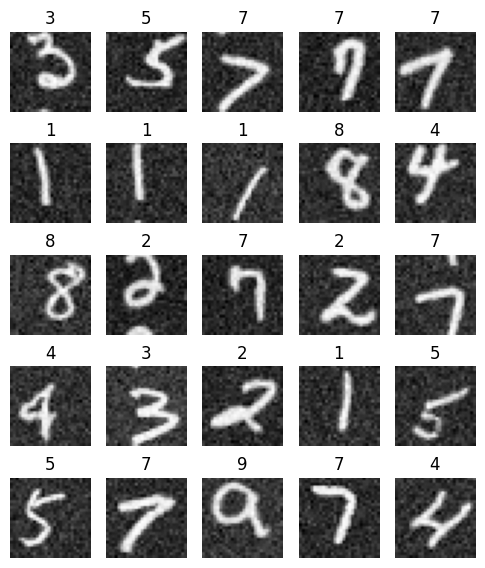

In [42]:
visualize_pictures(augmented_train_loader)

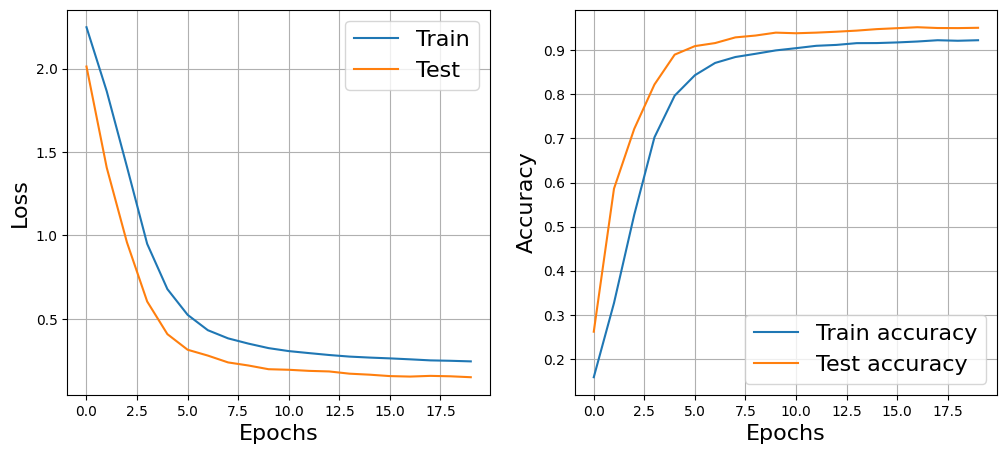

In [43]:
network = NeuralNetwork([Linear(784, 100), TanH(),
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_au, ts_au, tr_ac_au, ts_ac_au = train_custom(network, augmented_train_loader, 20, 0.01, plot=True, verbose=True)

In [44]:
ts_ac_au[-1]

np.float64(0.9509784345047924)

Точность получилась даже меньше, чем в других случаях. Однако "запас" до переобучения гораздо больше, то есть модель можно обучать на тех же данных, что мы и попробуем сделать

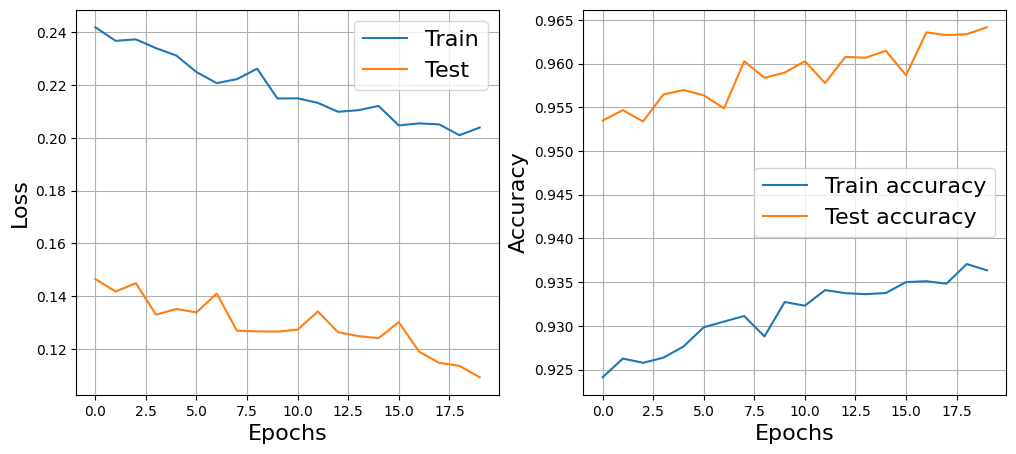

In [45]:
tr_au, ts_au, tr_ac_au, ts_ac_au = train_custom(network, augmented_train_loader, 20, 0.01, plot=True, verbose=True)

In [46]:
ts_ac_au[-1]

np.float64(0.9641573482428115)

Уже лучше. И видно, что потенциал ещё есть.

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

В результате исследования получилось, что нелинейности существенно влияют на результат предсказания моделей. Самый плохой результат показала функция Сигмоиды, остальные функции показали +- одинаковый хороший результат. Самой эффективной аугментацией с точки зрения точности стал поворот. Остальные (шум и сдвиг) влияют не сколько на точность, сколько на вероятность переобучения - она становится меньше. Совместное же применение указанных аугментаций приводит к "профилактике" переобучения, и как следствие - к возможности дальнейшего увеличения точности модели.